# Preamble


In [1]:
# reload modules
from importlib import reload

# load pretrained segmentation models (written in pytorch)
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.encoders import get_preprocessing_fn

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim

# torchvision
from torchviz import make_dot
import torchvision.transforms.v2 as TF

# torchmetrics
from torchmetrics.classification import Dice, BinaryJaccardIndex

# Serialize/Deserialize Json files
import json

# Data Augmentation
import albumentations as A
import albumentations.augmentations.functional as F
from albumentations.pytorch import ToTensorV2

# get data/time with desired format
from datetime import datetime

time_format = "%Y.%m.%d@%H-%M-%S"

# work with images
import cv2
from PIL import Image

# keep numpy use to a min
# as we store our torch.Tensors to GPU Vram but numpy in RAM (it only supports CPU)
import pandas as pd
import numpy as np

# to have a progress bar
from tqdm import tqdm

# To use pretrained segmentation models (implement in PyTorch)

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
from pprint import pprint
# uncomment if wan't to globally aloow sns to handle plot style
# it adds unwanted style (i.e., grid) to .imshow()
# so better to use it a context manager to style only what I want
# >>> with sns.axes_style('darkgrid'):
# >>>     plt.imshow(...)
# sns.set_theme(
#     context="notebook",
#     style="darkgrid",
#     palette="deep",
#     font="sans-serif",
#     font_scale=1,
#     color_codes=True,
#     rc={'axes.grid': False},
# )

# OS/File/Path management
import sys
import os

# load my custom Classes/Functions/etc.
from utils.dataset import SegmentaionDataset
from utils.models.unet import UnetScratch

/home/tekboart/.local/lib/python3.11/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/home/tekboart/.local/lib/python3.11/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have 

## Set up GPU use


In [2]:
print("PyTorch ver:", torch.__version__)

# set max_split_size_mb to avoid GPU VRAM (out of MEM error)
# Could use terminal/shell instead:
# for linux: export 'PYTORCH_CUDA_ALLOC_CONF=max_split_size_mb:512'
# for winows: set 'PYTORCH_CUDA_ALLOC_CONF=max_split_size_mb:512'
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:512"

# force pytorch to use GPU
# use "model.to(device)" later on to force a model use Cuda GPU
print("Can I use GPU?", torch.cuda.is_available())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device used for calculation (CPU\Cuda):", device)

PyTorch ver: 2.0.1+cu118
Can I use GPU? True
Device used for calculation (CPU\Cuda): cuda:0


## Set Hyperparameters


In [3]:
hyper_params = {
    "lr": 1e-3,
    "batch_size": 4,
    "num_classes": 1,
    "epochs": 10,
    "num_workers": 2,
    "image_height": 352,
    "image_width": 352,
    "num_classes": 1,
    "pin_mem": True,
    "load_model": False,
    "load_model_path": os.path.join("models"),
    "train_img_dir": os.path.join("data", "traincrop", "img"),
    "train_mask_dir": os.path.join("data", "traincrop", "mask"),
    "val_img_dir": os.path.join("data", "valcrop", "img"),
    "val_mask_dir": os.path.join("data", "valcrop", "mask"),
    "test_img_dir": os.path.join("data", "testcrop", "img"),
    "test_mask_dir": os.path.join("data", "testcrop", "mask"),
    "lr_decay_step": 10,
    "lr_decary_factor": 0.5,
}

# device = device
# lr = 1e-4
# # due to limited Mem I values larger than 4 raise GPU MEM Error
# batch_size = 16
# epochs = 10
# num_workers = 2
# # for UNet the H/W must be a factor of 32
# image_height = 384
# image_width = 640
# num_classes = 1
# pin_mem = True
# load_model = False
# load_model_path = os.path.join('models')

# # define path(s)
# train_img_dir = os.path.join("data", "traincrop", "img")
# train_mask_dir = os.path.join("data", "traincrop", "mask")
# val_img_dir = os.path.join("data", "valcrop", "img")
# val_mask_dir = os.path.join("data", "valcrop", "mask")
# test_img_dir = os.path.join("data", "testcrop", "img")
# test_mask_dir = os.path.join("data", "testcrop", "mask")

# Create Dataset


In [4]:
from utils.dataset import get_loaders, SegmentaionDataset
import utils.dataset
reload(utils.dataset)


# Define a set of augmentations (resize, rescale, augmentation, etc.)
train_transform = A.Compose(
    [
        A.Resize(height=hyper_params['image_height'],
                 width=hyper_params['image_width']),
        A.Rotate(limit=35, p=1.0),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.1),
        # A.RandomRotate90(p=1),  # Use only when the img_height==img_width
        # A.Transpose(p=1),  # Use only when the img_height==img_width
        # A.RandomBrightnessContrast(p=0.8),
        A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2,
                      hue=0.2, always_apply=False, p=0.8),
        A.ImageCompression(quality_lower=99, quality_upper=100, p=0.5),
        A.RGBShift(r_shift_limit=10, g_shift_limit=10,
                   b_shift_limit=10, p=0.5),
        # this is for z-scoring
        # TODO: add pretrained model's own preprocess layer
        A.Normalize(mean=[0.0, 0.0, 0, 0], std=[
                    1.0, 1.0, 1.0], max_pixel_value=255.0),
        # ToTensorV2(),
    ],
    # is_check_shapes=False,  # risky
)

# we don't want TTA, just some resize, normalization, etc.
val_transform = A.Compose(
    [
        A.Resize(height=hyper_params['image_height'],
                 width=hyper_params['image_width']),
        # TODO: add pretrained model's own preprocess layer
        A.Normalize(mean=[0.0, 0.0, 0, 0], std=[
                    1.0, 1.0, 1.0], max_pixel_value=255.0),
        # ToTensorV2(),
    ],
    # is_check_shapes=False,  # risky
)

# create our datasets (with our custom Class)
train_ds = SegmentaionDataset(
    image_dir=hyper_params['train_img_dir'],
    mask_dir=hyper_params['train_mask_dir'],
    transform=train_transform,
    mask_suffix="",
    subset=[0, 10],
)
val_ds = SegmentaionDataset(
    image_dir=hyper_params['val_img_dir'],
    mask_dir=hyper_params['val_mask_dir'],
    transform=val_transform,
    mask_suffix="",
    subset=[0, 5],
)
test_ds = SegmentaionDataset(
    image_dir=hyper_params['test_img_dir'],
    mask_dir=hyper_params['test_mask_dir'],
    transform=val_transform,
    mask_suffix="",
    subset=[0, 5],
)

# Create Datatset by data loaders
train_loader, val_loader, test_loader = get_loaders(
    train_ds,
    val_ds,
    test_ds,
    hyper_params['batch_size'],
    hyper_params['num_workers'],
    hyper_params['pin_mem'],
)

In [5]:
# (Fast) Using Dataset's __len__ magic method (always work)
print("# train images:", len(train_ds))
print("# val images:", len(val_ds))
print("# test images:", len(test_ds))

# (Slow) Using Data Loader (is a hit or miss)
# print('# train images:', sum(len(batch) for batch in train_loader))
# print('# val images:', sum(len(batch) for batch in val_loader))

# this outputs wrong nume (why??)
# it's not even the #imgs in mini_batch??
# print(len(train_loader))

# train images: 1896
# val images: 348
# test images: 5


## Visualize Dataset(s)


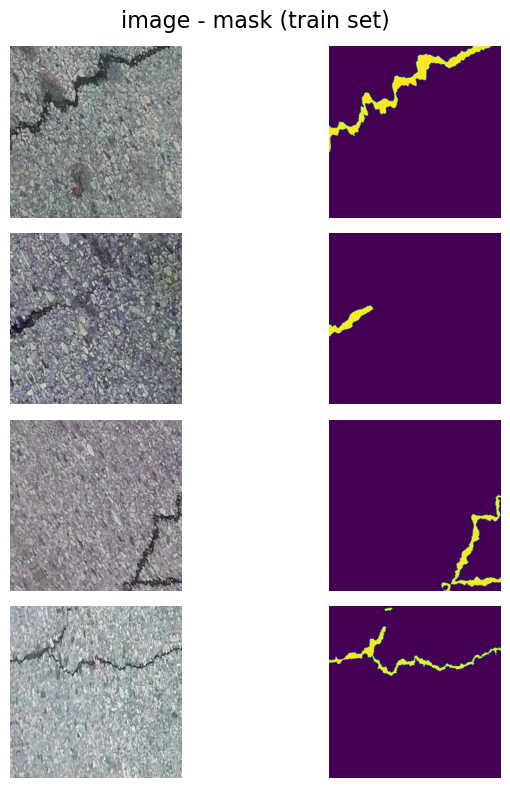

In [5]:
img_mask_iter = ((img, mask) for img, mask in train_ds)

plt.figure(figsize=(8, 8))
for i in range(0, 4 * 2, 2):
    img, mask = next(img_mask_iter)
    plt.subplot(4, 2, i + 1)
    plt.imshow(np.moveaxis(img, 0, -1))
    plt.axis("off")
    plt.subplot(4, 2, i + 2)
    plt.imshow(np.moveaxis(mask, 0, -1))
    plt.axis("off")

plt.suptitle("image - mask (train set)", fontsize=16)
plt.tight_layout()
plt.show()

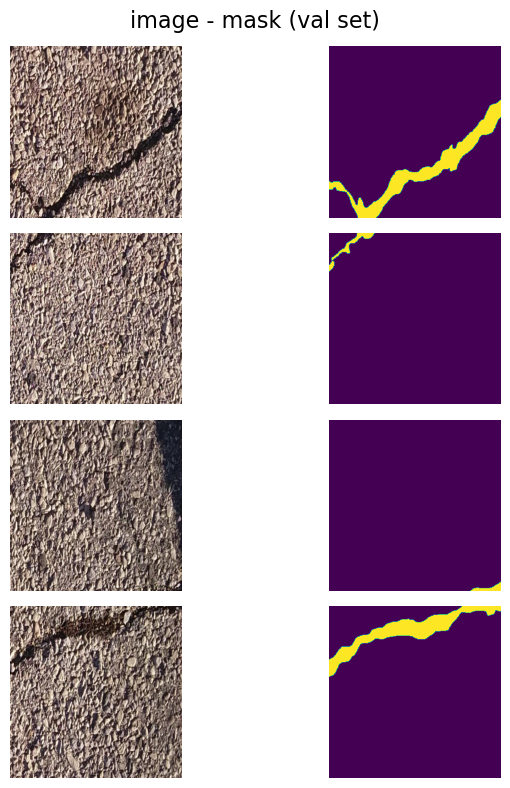

In [6]:
img_mask_iter = ((img, mask) for img, mask in val_ds)

plt.figure(figsize=(8, 8))
for i in range(0, 8, 2):
    img, mask = next(img_mask_iter)
    plt.subplot(4, 2, i + 1)
    plt.imshow(np.moveaxis(img, 0, -1))
    plt.axis("off")
    plt.subplot(4, 2, i + 2)
    plt.imshow(np.moveaxis(mask, 0, -1))
    plt.axis("off")

plt.suptitle("image - mask (val set)", fontsize=16)
plt.tight_layout()
plt.show()

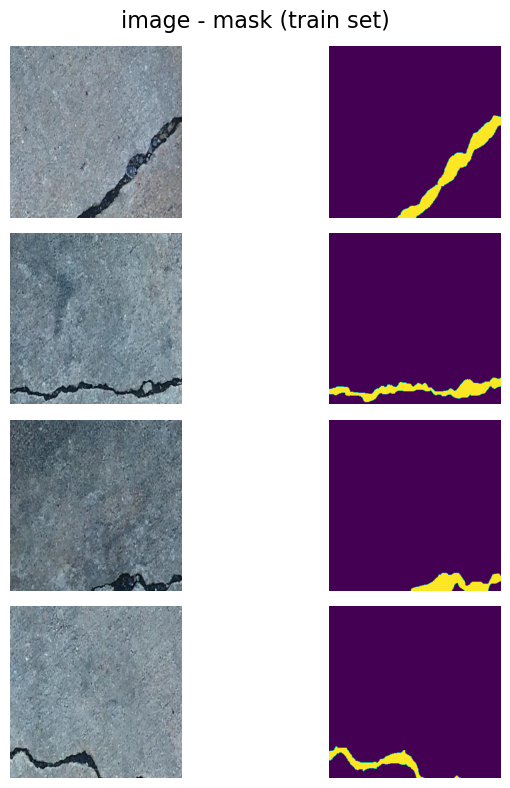

In [7]:
img_mask_iter = ((img, mask) for img, mask in test_ds)

plt.figure(figsize=(8, 8))
for i in range(0, 8, 2):
    img, mask = next(img_mask_iter)
    plt.subplot(4, 2, i + 1)
    plt.imshow(np.moveaxis(img, 0, -1))
    plt.axis("off")
    plt.subplot(4, 2, i + 2)
    plt.imshow(np.moveaxis(mask, 0, -1))
    plt.axis("off")

plt.suptitle("image - mask (train set)", fontsize=16)
plt.tight_layout()
plt.show()

# Define Model(s)


## Import a Pretrained Segmentaion model (e.g., UNET)


In [8]:
# the downloaded model are located in "~/.cache/torch/hub/checkpoints/"
# backbone_model_name = 'resnet152'
backbone_model_name = 'mobilenet_v2'

# Segmentation model is just a PyTorch nn.Module
# model = smp.FPN(
model = smp.Unet(
    # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_name=backbone_model_name,
    # use `imagenet` pre-trained weights for encoder initialization
    encoder_weights="imagenet",
    # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    in_channels=3,
    # model output channels (number of classes in your dataset)
    classes=hyper_params['num_classes'],
)

# load preprocessing func of the loaded model, so our data goes through the same transformation
# hint 1: it needs the input img to be in channels_last format
# hint 2: it outputs the image in channels_last format! (e.g., toch.Size[640, 360, 3])
preprocess_input = get_preprocessing_fn(
    backbone_model_name, pretrained='imagenet')

### Visualize the architecture


In [ ]:
# the attribs of the model
# vars(model)

# plot the model arch
# create a dumy channels_first img (m, C, H, W)
x = torch.zeros(1, 3, 224, 224, dtype=torch.float, requires_grad=False)
# must do a forward pass (to init weights so shapes are set)
yhat = model(x)
print(yhat.shape)

# save the architecture of the model as an image
# make_dot(yhat, params=dict(list(model.named_parameters()))).render("./outputs/model_plot/Unet_pretrained", format="png")

### Test the model with an img


## Load a Segmentation Model (i.e., UNET), written from scratch


In [ ]:
model = UnetScratch(in_channels=3, num_classes=hyper_params["num_classes"])

# Train


In [10]:
from utils.metrics import (
    AccuracyBinarySegment,
    DiceBinarySegment,
    JaccardBinarySegment,
)

from utils.training import train_model
import utils.training
import utils.metrics

reload(utils.training)
reload(utils.metrics)


# a dict to map metrics' name to correspoing fn
metrics_fn = {
    "accuracy": AccuracyBinarySegment(),
    "dice": DiceBinarySegment(),  # my custom dice
    "jaccard": JaccardBinarySegment(),  # my custom jaccard
    # "dice_torch": Dice(average="micro").to(device),
    # "jaccard_torch": BinaryJaccardIndex().to(device),
}

# get the date-time (for filenames)
start_train_time = datetime.today().strftime(time_format)

# save hyperparams as a JSON file
hyper_params_export_name = f"outputs/hyperparams/{start_train_time}@hyperparams.json"
with open(hyper_params_export_name, "w") as f:
    json.dump(hyper_params, f)

# save the hyperparams to a csv file
# df_hyperparam = pd.DataFrame(hyper_params, index=[0]).T
# df_hyperparam.to_csv(f'outputs/hyperparams/{start_train_time}@hyperparams.csv', index=True, header=None)
# print('The HyperParameters'.ljust(79, " "))
# display(df_hyperparam)
# del df_hyperparam

# train the model
history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    from_logits=True,
    epochs=hyper_params["epochs"],
    lr=hyper_params["lr"],
    device=device,
    metrics_fn=metrics_fn,
    save_model=True,
    save_model_path="models/",
    save_model_temp=True,
    save_model_temp_path="temp/epoch_best_model_checkpoint/",
)

--------------------------------- epoch 1/100 ---------------------------------


Epoch 1: 100%|██████████| 237/237 [00:11<00:00, 20.29it/s]



loss:                0.168276  
jaccard:             0.43      
dice:                0.58      
accuracy:            0.94      
val_loss:            0.077438  
val_jaccard:         0.55      
val_dice:            0.70      
val_accuracy:        0.97      
--------------------------------- epoch 2/100 ---------------------------------


Epoch 2: 100%|██████████| 237/237 [00:13<00:00, 17.80it/s]



loss:                0.095148  
jaccard:             0.53      
dice:                0.69      
accuracy:            0.96      
val_loss:            0.072433  
val_jaccard:         0.59      
val_dice:            0.73      
val_accuracy:        0.97      
--------------------------------- epoch 3/100 ---------------------------------


Epoch 3: 100%|██████████| 237/237 [00:11<00:00, 20.11it/s]



loss:                0.087956  
jaccard:             0.56      
dice:                0.71      
accuracy:            0.97      
val_loss:            0.064461  
val_jaccard:         0.57      
val_dice:            0.71      
val_accuracy:        0.97      
--------------------------------- epoch 4/100 ---------------------------------


Epoch 4: 100%|██████████| 237/237 [00:11<00:00, 20.45it/s]



loss:                0.087447  
jaccard:             0.56      
dice:                0.72      
accuracy:            0.97      
val_loss:            0.066229  
val_jaccard:         0.60      
val_dice:            0.74      
val_accuracy:        0.98      
--------------------------------- epoch 5/100 ---------------------------------


Epoch 5: 100%|██████████| 237/237 [00:11<00:00, 21.05it/s]



loss:                0.085509  
jaccard:             0.58      
dice:                0.73      
accuracy:            0.97      
val_loss:            0.062819  
val_jaccard:         0.60      
val_dice:            0.74      
val_accuracy:        0.98      
--------------------------------- epoch 6/100 ---------------------------------


Epoch 6: 100%|██████████| 237/237 [00:11<00:00, 20.44it/s]



loss:                0.082932  
jaccard:             0.58      
dice:                0.73      
accuracy:            0.97      
val_loss:            0.061285  
val_jaccard:         0.61      
val_dice:            0.75      
val_accuracy:        0.98      
--------------------------------- epoch 7/100 ---------------------------------


Epoch 7: 100%|██████████| 237/237 [00:12<00:00, 19.73it/s]



loss:                0.080915  
jaccard:             0.59      
dice:                0.74      
accuracy:            0.97      
val_loss:            0.062341  
val_jaccard:         0.60      
val_dice:            0.74      
val_accuracy:        0.98      
--------------------------------- epoch 8/100 ---------------------------------


Epoch 8: 100%|██████████| 237/237 [00:11<00:00, 20.30it/s]



loss:                0.081666  
jaccard:             0.59      
dice:                0.74      
accuracy:            0.97      
val_loss:            0.092532  
val_jaccard:         0.53      
val_dice:            0.67      
val_accuracy:        0.97      
--------------------------------- epoch 9/100 ---------------------------------


Epoch 9: 100%|██████████| 237/237 [00:10<00:00, 21.66it/s]



loss:                0.079367  
jaccard:             0.60      
dice:                0.75      
accuracy:            0.97      
val_loss:            0.079491  
val_jaccard:         0.56      
val_dice:            0.69      
val_accuracy:        0.96      
--------------------------------- epoch 10/100 --------------------------------


Epoch 10: 100%|██████████| 237/237 [00:10<00:00, 22.22it/s]



loss:                0.079126  
jaccard:             0.60      
dice:                0.75      
accuracy:            0.97      
val_loss:            0.061067  
val_jaccard:         0.63      
val_dice:            0.76      
val_accuracy:        0.98      
--------------------------------- epoch 11/100 --------------------------------


Epoch 11: 100%|██████████| 237/237 [00:10<00:00, 21.73it/s]



loss:                0.075823  
jaccard:             0.61      
dice:                0.76      
accuracy:            0.97      
val_loss:            0.058257  
val_jaccard:         0.63      
val_dice:            0.76      
val_accuracy:        0.98      
--------------------------------- epoch 12/100 --------------------------------


Epoch 12: 100%|██████████| 237/237 [00:10<00:00, 21.97it/s]



loss:                0.073827  
jaccard:             0.62      
dice:                0.76      
accuracy:            0.97      
val_loss:            0.057359  
val_jaccard:         0.64      
val_dice:            0.77      
val_accuracy:        0.98      
--------------------------------- epoch 13/100 --------------------------------


Epoch 13: 100%|██████████| 237/237 [00:10<00:00, 22.58it/s]



loss:                0.073415  
jaccard:             0.62      
dice:                0.76      
accuracy:            0.97      
val_loss:            0.059354  
val_jaccard:         0.65      
val_dice:            0.78      
val_accuracy:        0.98      
--------------------------------- epoch 14/100 --------------------------------


Epoch 14: 100%|██████████| 237/237 [00:10<00:00, 21.87it/s]



loss:                0.073245  
jaccard:             0.62      
dice:                0.76      
accuracy:            0.97      
val_loss:            0.057657  
val_jaccard:         0.59      
val_dice:            0.73      
val_accuracy:        0.98      
--------------------------------- epoch 15/100 --------------------------------


Epoch 15: 100%|██████████| 237/237 [00:10<00:00, 21.77it/s]



loss:                0.072174  
jaccard:             0.62      
dice:                0.77      
accuracy:            0.97      
val_loss:            0.058025  
val_jaccard:         0.61      
val_dice:            0.75      
val_accuracy:        0.98      
--------------------------------- epoch 16/100 --------------------------------


Epoch 16: 100%|██████████| 237/237 [00:10<00:00, 22.56it/s]



loss:                0.073217  
jaccard:             0.62      
dice:                0.76      
accuracy:            0.97      
val_loss:            0.064177  
val_jaccard:         0.61      
val_dice:            0.74      
val_accuracy:        0.97      
--------------------------------- epoch 17/100 --------------------------------


Epoch 17: 100%|██████████| 237/237 [00:10<00:00, 22.15it/s]



loss:                0.071345  
jaccard:             0.63      
dice:                0.77      
accuracy:            0.97      
val_loss:            0.055265  
val_jaccard:         0.64      
val_dice:            0.77      
val_accuracy:        0.98      
--------------------------------- epoch 18/100 --------------------------------


Epoch 18: 100%|██████████| 237/237 [00:10<00:00, 21.60it/s]



loss:                0.071133  
jaccard:             0.63      
dice:                0.77      
accuracy:            0.97      
val_loss:            0.056729  
val_jaccard:         0.61      
val_dice:            0.74      
val_accuracy:        0.98      
--------------------------------- epoch 19/100 --------------------------------


Epoch 19: 100%|██████████| 237/237 [00:10<00:00, 22.52it/s]



loss:                0.072196  
jaccard:             0.62      
dice:                0.77      
accuracy:            0.97      
val_loss:            0.055166  
val_jaccard:         0.64      
val_dice:            0.77      
val_accuracy:        0.98      
--------------------------------- epoch 20/100 --------------------------------


Epoch 20: 100%|██████████| 237/237 [00:10<00:00, 21.66it/s]



loss:                0.070262  
jaccard:             0.63      
dice:                0.77      
accuracy:            0.97      
val_loss:            0.062280  
val_jaccard:         0.60      
val_dice:            0.73      
val_accuracy:        0.98      
--------------------------------- epoch 21/100 --------------------------------


Epoch 21: 100%|██████████| 237/237 [00:10<00:00, 22.22it/s]



loss:                0.068545  
jaccard:             0.64      
dice:                0.77      
accuracy:            0.97      
val_loss:            0.053397  
val_jaccard:         0.65      
val_dice:            0.77      
val_accuracy:        0.98      
--------------------------------- epoch 22/100 --------------------------------


Epoch 22: 100%|██████████| 237/237 [00:10<00:00, 22.02it/s]



loss:                0.067071  
jaccard:             0.64      
dice:                0.78      
accuracy:            0.97      
val_loss:            0.052784  
val_jaccard:         0.65      
val_dice:            0.78      
val_accuracy:        0.98      
--------------------------------- epoch 23/100 --------------------------------


Epoch 23: 100%|██████████| 237/237 [00:10<00:00, 22.66it/s]



loss:                0.067163  
jaccard:             0.64      
dice:                0.78      
accuracy:            0.97      
val_loss:            0.056176  
val_jaccard:         0.63      
val_dice:            0.76      
val_accuracy:        0.98      
--------------------------------- epoch 24/100 --------------------------------


Epoch 24: 100%|██████████| 237/237 [00:10<00:00, 22.13it/s]



loss:                0.066800  
jaccard:             0.64      
dice:                0.78      
accuracy:            0.97      
val_loss:            0.053950  
val_jaccard:         0.64      
val_dice:            0.77      
val_accuracy:        0.98      
--------------------------------- epoch 25/100 --------------------------------


Epoch 25: 100%|██████████| 237/237 [00:10<00:00, 21.91it/s]



loss:                0.065146  
jaccard:             0.64      
dice:                0.78      
accuracy:            0.97      
val_loss:            0.053124  
val_jaccard:         0.65      
val_dice:            0.77      
val_accuracy:        0.98      
--------------------------------- epoch 26/100 --------------------------------


Epoch 26: 100%|██████████| 237/237 [00:10<00:00, 21.81it/s]



loss:                0.065677  
jaccard:             0.64      
dice:                0.78      
accuracy:            0.97      
val_loss:            0.052909  
val_jaccard:         0.65      
val_dice:            0.77      
val_accuracy:        0.98      
--------------------------------- epoch 27/100 --------------------------------


Epoch 27: 100%|██████████| 237/237 [00:10<00:00, 22.06it/s]



loss:                0.065565  
jaccard:             0.65      
dice:                0.78      
accuracy:            0.97      
val_loss:            0.054117  
val_jaccard:         0.64      
val_dice:            0.77      
val_accuracy:        0.98      
--------------------------------- epoch 28/100 --------------------------------


Epoch 28: 100%|██████████| 237/237 [00:10<00:00, 22.50it/s]



loss:                0.065169  
jaccard:             0.65      
dice:                0.78      
accuracy:            0.97      
val_loss:            0.054158  
val_jaccard:         0.64      
val_dice:            0.77      
val_accuracy:        0.98      
--------------------------------- epoch 29/100 --------------------------------


Epoch 29: 100%|██████████| 237/237 [00:11<00:00, 21.28it/s]



loss:                0.064695  
jaccard:             0.65      
dice:                0.78      
accuracy:            0.97      
val_loss:            0.053583  
val_jaccard:         0.64      
val_dice:            0.76      
val_accuracy:        0.98      
--------------------------------- epoch 30/100 --------------------------------


Epoch 30: 100%|██████████| 237/237 [00:10<00:00, 22.09it/s]



loss:                0.064604  
jaccard:             0.65      
dice:                0.78      
accuracy:            0.97      
val_loss:            0.052198  
val_jaccard:         0.65      
val_dice:            0.78      
val_accuracy:        0.98      
--------------------------------- epoch 31/100 --------------------------------


Epoch 31: 100%|██████████| 237/237 [00:10<00:00, 22.18it/s]



loss:                0.062931  
jaccard:             0.65      
dice:                0.79      
accuracy:            0.97      
val_loss:            0.052488  
val_jaccard:         0.65      
val_dice:            0.77      
val_accuracy:        0.98      
--------------------------------- epoch 32/100 --------------------------------


Epoch 32: 100%|██████████| 237/237 [00:10<00:00, 22.32it/s]



loss:                0.061574  
jaccard:             0.66      
dice:                0.79      
accuracy:            0.98      
val_loss:            0.051606  
val_jaccard:         0.64      
val_dice:            0.77      
val_accuracy:        0.98      
--------------------------------- epoch 33/100 --------------------------------


Epoch 33: 100%|██████████| 237/237 [00:10<00:00, 21.63it/s]



loss:                0.062360  
jaccard:             0.65      
dice:                0.79      
accuracy:            0.98      
val_loss:            0.053354  
val_jaccard:         0.64      
val_dice:            0.77      
val_accuracy:        0.98      
--------------------------------- epoch 34/100 --------------------------------


Epoch 34: 100%|██████████| 237/237 [00:10<00:00, 22.36it/s]



loss:                0.062015  
jaccard:             0.66      
dice:                0.79      
accuracy:            0.98      
val_loss:            0.052896  
val_jaccard:         0.64      
val_dice:            0.77      
val_accuracy:        0.98      
--------------------------------- epoch 35/100 --------------------------------


Epoch 35: 100%|██████████| 237/237 [00:10<00:00, 22.61it/s]



loss:                0.062163  
jaccard:             0.66      
dice:                0.79      
accuracy:            0.98      
val_loss:            0.052725  
val_jaccard:         0.65      
val_dice:            0.77      
val_accuracy:        0.98      
--------------------------------- epoch 36/100 --------------------------------


Epoch 36: 100%|██████████| 237/237 [00:10<00:00, 21.84it/s]



loss:                0.062597  
jaccard:             0.65      
dice:                0.79      
accuracy:            0.98      
val_loss:            0.052883  
val_jaccard:         0.65      
val_dice:            0.78      
val_accuracy:        0.98      
--------------------------------- epoch 37/100 --------------------------------


Epoch 37: 100%|██████████| 237/237 [00:10<00:00, 22.42it/s]



loss:                0.061311  
jaccard:             0.66      
dice:                0.79      
accuracy:            0.98      
val_loss:            0.051615  
val_jaccard:         0.65      
val_dice:            0.78      
val_accuracy:        0.98      
--------------------------------- epoch 38/100 --------------------------------


Epoch 38: 100%|██████████| 237/237 [00:10<00:00, 22.06it/s]



loss:                0.061964  
jaccard:             0.66      
dice:                0.79      
accuracy:            0.98      
val_loss:            0.052529  
val_jaccard:         0.65      
val_dice:            0.78      
val_accuracy:        0.98      
--------------------------------- epoch 39/100 --------------------------------


Epoch 39: 100%|██████████| 237/237 [00:10<00:00, 22.33it/s]



loss:                0.061148  
jaccard:             0.66      
dice:                0.80      
accuracy:            0.98      
val_loss:            0.052218  
val_jaccard:         0.65      
val_dice:            0.77      
val_accuracy:        0.98      
--------------------------------- epoch 40/100 --------------------------------


Epoch 40: 100%|██████████| 237/237 [00:10<00:00, 21.96it/s]



loss:                0.061416  
jaccard:             0.66      
dice:                0.79      
accuracy:            0.98      
val_loss:            0.052562  
val_jaccard:         0.65      
val_dice:            0.77      
val_accuracy:        0.98      
--------------------------------- epoch 41/100 --------------------------------


Epoch 41: 100%|██████████| 237/237 [00:10<00:00, 21.78it/s]



loss:                0.060220  
jaccard:             0.66      
dice:                0.80      
accuracy:            0.98      
val_loss:            0.052267  
val_jaccard:         0.65      
val_dice:            0.77      
val_accuracy:        0.98      
--------------------------------- epoch 42/100 --------------------------------


Epoch 42: 100%|██████████| 237/237 [00:10<00:00, 22.69it/s]



loss:                0.060406  
jaccard:             0.66      
dice:                0.80      
accuracy:            0.98      
val_loss:            0.052400  
val_jaccard:         0.65      
val_dice:            0.77      
val_accuracy:        0.98      
--------------------------------- epoch 43/100 --------------------------------


Epoch 43: 100%|██████████| 237/237 [00:10<00:00, 22.44it/s]



loss:                0.060340  
jaccard:             0.67      
dice:                0.80      
accuracy:            0.98      
val_loss:            0.052345  
val_jaccard:         0.65      
val_dice:            0.77      
val_accuracy:        0.98      
--------------------------------- epoch 44/100 --------------------------------


Epoch 44: 100%|██████████| 237/237 [00:10<00:00, 22.06it/s]



loss:                0.059690  
jaccard:             0.66      
dice:                0.80      
accuracy:            0.98      
val_loss:            0.052636  
val_jaccard:         0.65      
val_dice:            0.77      
val_accuracy:        0.98      
--------------------------------- epoch 45/100 --------------------------------


Epoch 45: 100%|██████████| 237/237 [00:10<00:00, 21.99it/s]



loss:                0.059699  
jaccard:             0.67      
dice:                0.80      
accuracy:            0.98      
val_loss:            0.052388  
val_jaccard:         0.65      
val_dice:            0.77      
val_accuracy:        0.98      
--------------------------------- epoch 46/100 --------------------------------


Epoch 46: 100%|██████████| 237/237 [00:10<00:00, 22.12it/s]



loss:                0.059568  
jaccard:             0.67      
dice:                0.80      
accuracy:            0.98      
val_loss:            0.051909  
val_jaccard:         0.65      
val_dice:            0.77      
val_accuracy:        0.98      
--------------------------------- epoch 47/100 --------------------------------


Epoch 47: 100%|██████████| 237/237 [00:10<00:00, 22.22it/s]



loss:                0.060305  
jaccard:             0.66      
dice:                0.80      
accuracy:            0.98      
val_loss:            0.053147  
val_jaccard:         0.64      
val_dice:            0.77      
val_accuracy:        0.98      
--------------------------------- epoch 48/100 --------------------------------


Epoch 48: 100%|██████████| 237/237 [00:10<00:00, 22.43it/s]



loss:                0.059147  
jaccard:             0.67      
dice:                0.80      
accuracy:            0.98      
val_loss:            0.052292  
val_jaccard:         0.64      
val_dice:            0.77      
val_accuracy:        0.98      
--------------------------------- epoch 49/100 --------------------------------


Epoch 49: 100%|██████████| 237/237 [00:10<00:00, 21.94it/s]



loss:                0.059034  
jaccard:             0.67      
dice:                0.80      
accuracy:            0.98      
val_loss:            0.052078  
val_jaccard:         0.64      
val_dice:            0.77      
val_accuracy:        0.98      
--------------------------------- epoch 50/100 --------------------------------


Epoch 50: 100%|██████████| 237/237 [00:10<00:00, 22.25it/s]



loss:                0.059026  
jaccard:             0.67      
dice:                0.80      
accuracy:            0.98      
val_loss:            0.052033  
val_jaccard:         0.65      
val_dice:            0.77      
val_accuracy:        0.98      
--------------------------------- epoch 51/100 --------------------------------


Epoch 51: 100%|██████████| 237/237 [00:10<00:00, 22.11it/s]



loss:                0.058462  
jaccard:             0.67      
dice:                0.80      
accuracy:            0.98      
val_loss:            0.052378  
val_jaccard:         0.65      
val_dice:            0.77      
val_accuracy:        0.98      
--------------------------------- epoch 52/100 --------------------------------


Epoch 52: 100%|██████████| 237/237 [00:10<00:00, 22.13it/s]



loss:                0.058960  
jaccard:             0.67      
dice:                0.80      
accuracy:            0.98      
val_loss:            0.052019  
val_jaccard:         0.64      
val_dice:            0.77      
val_accuracy:        0.98      
--------------------------------- epoch 53/100 --------------------------------


Epoch 53: 100%|██████████| 237/237 [00:10<00:00, 21.60it/s]



loss:                0.058386  
jaccard:             0.67      
dice:                0.80      
accuracy:            0.98      
val_loss:            0.051928  
val_jaccard:         0.65      
val_dice:            0.77      
val_accuracy:        0.98      
--------------------------------- epoch 54/100 --------------------------------


Epoch 54: 100%|██████████| 237/237 [00:10<00:00, 22.01it/s]



loss:                0.058540  
jaccard:             0.67      
dice:                0.80      
accuracy:            0.98      
val_loss:            0.052418  
val_jaccard:         0.65      
val_dice:            0.78      
val_accuracy:        0.98      
--------------------------------- epoch 55/100 --------------------------------


Epoch 55: 100%|██████████| 237/237 [00:10<00:00, 22.41it/s]



loss:                0.058200  
jaccard:             0.67      
dice:                0.80      
accuracy:            0.98      
val_loss:            0.052878  
val_jaccard:         0.64      
val_dice:            0.77      
val_accuracy:        0.98      
--------------------------------- epoch 56/100 --------------------------------


Epoch 56: 100%|██████████| 237/237 [00:10<00:00, 22.49it/s]



loss:                0.058134  
jaccard:             0.67      
dice:                0.80      
accuracy:            0.98      
val_loss:            0.052953  
val_jaccard:         0.65      
val_dice:            0.77      
val_accuracy:        0.98      
--------------------------------- epoch 57/100 --------------------------------


Epoch 57: 100%|██████████| 237/237 [00:11<00:00, 21.48it/s]



loss:                0.057379  
jaccard:             0.67      
dice:                0.80      
accuracy:            0.98      
val_loss:            0.052208  
val_jaccard:         0.65      
val_dice:            0.78      
val_accuracy:        0.98      
--------------------------------- epoch 58/100 --------------------------------


Epoch 58: 100%|██████████| 237/237 [00:10<00:00, 22.28it/s]



loss:                0.057954  
jaccard:             0.67      
dice:                0.80      
accuracy:            0.98      
val_loss:            0.052969  
val_jaccard:         0.64      
val_dice:            0.77      
val_accuracy:        0.98      
--------------------------------- epoch 59/100 --------------------------------


Epoch 59: 100%|██████████| 237/237 [00:10<00:00, 22.16it/s]



loss:                0.057806  
jaccard:             0.67      
dice:                0.80      
accuracy:            0.98      
val_loss:            0.052954  
val_jaccard:         0.65      
val_dice:            0.77      
val_accuracy:        0.98      
--------------------------------- epoch 60/100 --------------------------------


Epoch 60: 100%|██████████| 237/237 [00:10<00:00, 22.03it/s]



loss:                0.058021  
jaccard:             0.67      
dice:                0.80      
accuracy:            0.98      
val_loss:            0.052616  
val_jaccard:         0.65      
val_dice:            0.77      
val_accuracy:        0.98      
--------------------------------- epoch 61/100 --------------------------------


Epoch 61: 100%|██████████| 237/237 [00:10<00:00, 21.87it/s]



loss:                0.057772  
jaccard:             0.67      
dice:                0.80      
accuracy:            0.98      
val_loss:            0.052759  
val_jaccard:         0.65      
val_dice:            0.77      
val_accuracy:        0.98      
--------------------------------- epoch 62/100 --------------------------------


Epoch 62: 100%|██████████| 237/237 [00:10<00:00, 22.44it/s]



loss:                0.057600  
jaccard:             0.67      
dice:                0.80      
accuracy:            0.98      
val_loss:            0.052791  
val_jaccard:         0.65      
val_dice:            0.77      
val_accuracy:        0.98      
--------------------------------- epoch 63/100 --------------------------------


Epoch 63: 100%|██████████| 237/237 [00:10<00:00, 21.98it/s]



loss:                0.057660  
jaccard:             0.67      
dice:                0.80      
accuracy:            0.98      
val_loss:            0.052596  
val_jaccard:         0.64      
val_dice:            0.77      
val_accuracy:        0.98      
--------------------------------- epoch 64/100 --------------------------------


Epoch 64: 100%|██████████| 237/237 [00:10<00:00, 21.96it/s]



loss:                0.057315  
jaccard:             0.67      
dice:                0.80      
accuracy:            0.98      
val_loss:            0.052835  
val_jaccard:         0.65      
val_dice:            0.77      
val_accuracy:        0.98      
--------------------------------- epoch 65/100 --------------------------------


Epoch 65: 100%|██████████| 237/237 [00:10<00:00, 22.03it/s]



loss:                0.057662  
jaccard:             0.67      
dice:                0.80      
accuracy:            0.98      
val_loss:            0.052626  
val_jaccard:         0.65      
val_dice:            0.77      
val_accuracy:        0.98      
--------------------------------- epoch 66/100 --------------------------------


Epoch 66: 100%|██████████| 237/237 [00:10<00:00, 21.65it/s]



loss:                0.057108  
jaccard:             0.68      
dice:                0.80      
accuracy:            0.98      
val_loss:            0.052324  
val_jaccard:         0.65      
val_dice:            0.78      
val_accuracy:        0.98      
--------------------------------- epoch 67/100 --------------------------------


Epoch 67: 100%|██████████| 237/237 [00:10<00:00, 22.02it/s]



loss:                0.057224  
jaccard:             0.68      
dice:                0.81      
accuracy:            0.98      
val_loss:            0.052492  
val_jaccard:         0.65      
val_dice:            0.77      
val_accuracy:        0.98      
--------------------------------- epoch 68/100 --------------------------------


Epoch 68: 100%|██████████| 237/237 [00:10<00:00, 21.75it/s]



loss:                0.057580  
jaccard:             0.67      
dice:                0.80      
accuracy:            0.98      
val_loss:            0.052591  
val_jaccard:         0.65      
val_dice:            0.77      
val_accuracy:        0.98      
--------------------------------- epoch 69/100 --------------------------------


Epoch 69: 100%|██████████| 237/237 [00:10<00:00, 22.11it/s]



loss:                0.057252  
jaccard:             0.67      
dice:                0.80      
accuracy:            0.98      
val_loss:            0.052141  
val_jaccard:         0.65      
val_dice:            0.78      
val_accuracy:        0.98      
--------------------------------- epoch 70/100 --------------------------------


Epoch 70: 100%|██████████| 237/237 [00:10<00:00, 22.55it/s]



loss:                0.057094  
jaccard:             0.68      
dice:                0.81      
accuracy:            0.98      
val_loss:            0.052847  
val_jaccard:         0.64      
val_dice:            0.77      
val_accuracy:        0.98      
--------------------------------- epoch 71/100 --------------------------------


Epoch 71: 100%|██████████| 237/237 [00:10<00:00, 22.07it/s]



loss:                0.057017  
jaccard:             0.68      
dice:                0.80      
accuracy:            0.98      
val_loss:            0.052408  
val_jaccard:         0.64      
val_dice:            0.77      
val_accuracy:        0.98      
--------------------------------- epoch 72/100 --------------------------------


Epoch 72: 100%|██████████| 237/237 [00:10<00:00, 21.89it/s]



loss:                0.056966  
jaccard:             0.68      
dice:                0.80      
accuracy:            0.98      
val_loss:            0.052141  
val_jaccard:         0.65      
val_dice:            0.78      
val_accuracy:        0.98      
--------------------------------- epoch 73/100 --------------------------------


Epoch 73: 100%|██████████| 237/237 [00:10<00:00, 21.90it/s]



loss:                0.057274  
jaccard:             0.67      
dice:                0.80      
accuracy:            0.98      
val_loss:            0.052568  
val_jaccard:         0.65      
val_dice:            0.78      
val_accuracy:        0.98      
--------------------------------- epoch 74/100 --------------------------------


Epoch 74: 100%|██████████| 237/237 [00:10<00:00, 22.09it/s]



loss:                0.057139  
jaccard:             0.68      
dice:                0.81      
accuracy:            0.98      
val_loss:            0.052958  
val_jaccard:         0.65      
val_dice:            0.77      
val_accuracy:        0.98      
--------------------------------- epoch 75/100 --------------------------------


Epoch 75: 100%|██████████| 237/237 [00:10<00:00, 21.93it/s]



loss:                0.056491  
jaccard:             0.68      
dice:                0.81      
accuracy:            0.98      
val_loss:            0.052780  
val_jaccard:         0.65      
val_dice:            0.77      
val_accuracy:        0.98      
--------------------------------- epoch 76/100 --------------------------------


Epoch 76: 100%|██████████| 237/237 [00:10<00:00, 22.21it/s]



loss:                0.057337  
jaccard:             0.67      
dice:                0.80      
accuracy:            0.98      
val_loss:            0.052883  
val_jaccard:         0.65      
val_dice:            0.77      
val_accuracy:        0.98      
--------------------------------- epoch 77/100 --------------------------------


Epoch 77: 100%|██████████| 237/237 [00:11<00:00, 21.47it/s]



loss:                0.057433  
jaccard:             0.67      
dice:                0.80      
accuracy:            0.98      
val_loss:            0.052420  
val_jaccard:         0.65      
val_dice:            0.77      
val_accuracy:        0.98      
--------------------------------- epoch 78/100 --------------------------------


Epoch 78: 100%|██████████| 237/237 [00:10<00:00, 22.52it/s]



loss:                0.056765  
jaccard:             0.68      
dice:                0.81      
accuracy:            0.98      
val_loss:            0.052500  
val_jaccard:         0.65      
val_dice:            0.78      
val_accuracy:        0.98      
--------------------------------- epoch 79/100 --------------------------------


Epoch 79: 100%|██████████| 237/237 [00:10<00:00, 21.73it/s]



loss:                0.056894  
jaccard:             0.67      
dice:                0.80      
accuracy:            0.98      
val_loss:            0.052520  
val_jaccard:         0.65      
val_dice:            0.78      
val_accuracy:        0.98      
--------------------------------- epoch 80/100 --------------------------------


Epoch 80: 100%|██████████| 237/237 [00:10<00:00, 21.85it/s]



loss:                0.057296  
jaccard:             0.67      
dice:                0.80      
accuracy:            0.98      
val_loss:            0.052232  
val_jaccard:         0.65      
val_dice:            0.78      
val_accuracy:        0.98      
--------------------------------- epoch 81/100 --------------------------------


Epoch 81: 100%|██████████| 237/237 [00:10<00:00, 21.79it/s]



loss:                0.056895  
jaccard:             0.67      
dice:                0.80      
accuracy:            0.98      
val_loss:            0.052065  
val_jaccard:         0.65      
val_dice:            0.78      
val_accuracy:        0.98      
--------------------------------- epoch 82/100 --------------------------------


Epoch 82: 100%|██████████| 237/237 [00:10<00:00, 22.52it/s]



loss:                0.057132  
jaccard:             0.67      
dice:                0.80      
accuracy:            0.98      
val_loss:            0.052975  
val_jaccard:         0.65      
val_dice:            0.77      
val_accuracy:        0.98      
--------------------------------- epoch 83/100 --------------------------------


Epoch 83: 100%|██████████| 237/237 [00:10<00:00, 21.94it/s]



loss:                0.056831  
jaccard:             0.67      
dice:                0.80      
accuracy:            0.98      
val_loss:            0.052683  
val_jaccard:         0.65      
val_dice:            0.77      
val_accuracy:        0.98      
--------------------------------- epoch 84/100 --------------------------------


Epoch 84: 100%|██████████| 237/237 [00:10<00:00, 22.58it/s]



loss:                0.056792  
jaccard:             0.68      
dice:                0.80      
accuracy:            0.98      
val_loss:            0.052439  
val_jaccard:         0.65      
val_dice:            0.77      
val_accuracy:        0.98      
--------------------------------- epoch 85/100 --------------------------------


Epoch 85: 100%|██████████| 237/237 [00:11<00:00, 20.71it/s]



loss:                0.056673  
jaccard:             0.67      
dice:                0.80      
accuracy:            0.98      
val_loss:            0.052726  
val_jaccard:         0.65      
val_dice:            0.77      
val_accuracy:        0.98      
--------------------------------- epoch 86/100 --------------------------------


Epoch 86: 100%|██████████| 237/237 [00:10<00:00, 21.65it/s]



loss:                0.056554  
jaccard:             0.68      
dice:                0.81      
accuracy:            0.98      
val_loss:            0.053345  
val_jaccard:         0.65      
val_dice:            0.77      
val_accuracy:        0.98      
--------------------------------- epoch 87/100 --------------------------------


Epoch 87: 100%|██████████| 237/237 [00:10<00:00, 21.65it/s]



loss:                0.056624  
jaccard:             0.67      
dice:                0.80      
accuracy:            0.98      
val_loss:            0.052767  
val_jaccard:         0.64      
val_dice:            0.77      
val_accuracy:        0.98      
--------------------------------- epoch 88/100 --------------------------------


Epoch 88: 100%|██████████| 237/237 [00:10<00:00, 22.49it/s]



loss:                0.056635  
jaccard:             0.68      
dice:                0.81      
accuracy:            0.98      
val_loss:            0.053147  
val_jaccard:         0.64      
val_dice:            0.77      
val_accuracy:        0.98      
--------------------------------- epoch 89/100 --------------------------------


Epoch 89: 100%|██████████| 237/237 [00:10<00:00, 22.19it/s]



loss:                0.056660  
jaccard:             0.68      
dice:                0.80      
accuracy:            0.98      
val_loss:            0.052593  
val_jaccard:         0.65      
val_dice:            0.77      
val_accuracy:        0.98      
--------------------------------- epoch 90/100 --------------------------------


Epoch 90: 100%|██████████| 237/237 [00:10<00:00, 21.61it/s]



loss:                0.057066  
jaccard:             0.68      
dice:                0.81      
accuracy:            0.98      
val_loss:            0.052504  
val_jaccard:         0.65      
val_dice:            0.77      
val_accuracy:        0.98      
--------------------------------- epoch 91/100 --------------------------------


Epoch 91: 100%|██████████| 237/237 [00:11<00:00, 21.40it/s]



loss:                0.056969  
jaccard:             0.68      
dice:                0.80      
accuracy:            0.98      
val_loss:            0.052492  
val_jaccard:         0.65      
val_dice:            0.77      
val_accuracy:        0.98      
--------------------------------- epoch 92/100 --------------------------------


Epoch 92: 100%|██████████| 237/237 [00:10<00:00, 21.86it/s]



loss:                0.056008  
jaccard:             0.68      
dice:                0.81      
accuracy:            0.98      
val_loss:            0.052685  
val_jaccard:         0.65      
val_dice:            0.78      
val_accuracy:        0.98      
--------------------------------- epoch 93/100 --------------------------------


Epoch 93: 100%|██████████| 237/237 [00:10<00:00, 21.70it/s]



loss:                0.056400  
jaccard:             0.68      
dice:                0.81      
accuracy:            0.98      
val_loss:            0.052966  
val_jaccard:         0.65      
val_dice:            0.77      
val_accuracy:        0.98      
--------------------------------- epoch 94/100 --------------------------------


Epoch 94: 100%|██████████| 237/237 [00:10<00:00, 21.91it/s]



loss:                0.056912  
jaccard:             0.68      
dice:                0.81      
accuracy:            0.98      
val_loss:            0.052735  
val_jaccard:         0.65      
val_dice:            0.77      
val_accuracy:        0.98      
--------------------------------- epoch 95/100 --------------------------------


Epoch 95: 100%|██████████| 237/237 [00:10<00:00, 21.97it/s]



loss:                0.056705  
jaccard:             0.68      
dice:                0.80      
accuracy:            0.98      
val_loss:            0.052398  
val_jaccard:         0.65      
val_dice:            0.78      
val_accuracy:        0.98      
--------------------------------- epoch 96/100 --------------------------------


Epoch 96: 100%|██████████| 237/237 [00:10<00:00, 21.85it/s]



loss:                0.056745  
jaccard:             0.68      
dice:                0.81      
accuracy:            0.98      
val_loss:            0.052408  
val_jaccard:         0.65      
val_dice:            0.77      
val_accuracy:        0.98      
--------------------------------- epoch 97/100 --------------------------------


Epoch 97: 100%|██████████| 237/237 [00:10<00:00, 22.80it/s]



loss:                0.057117  
jaccard:             0.67      
dice:                0.80      
accuracy:            0.98      
val_loss:            0.052361  
val_jaccard:         0.65      
val_dice:            0.77      
val_accuracy:        0.98      
--------------------------------- epoch 98/100 --------------------------------


Epoch 98: 100%|██████████| 237/237 [00:10<00:00, 21.62it/s]



loss:                0.057172  
jaccard:             0.68      
dice:                0.81      
accuracy:            0.98      
val_loss:            0.052368  
val_jaccard:         0.65      
val_dice:            0.77      
val_accuracy:        0.98      
--------------------------------- epoch 99/100 --------------------------------


Epoch 99: 100%|██████████| 237/237 [00:10<00:00, 21.93it/s]



loss:                0.056776  
jaccard:             0.67      
dice:                0.80      
accuracy:            0.98      
val_loss:            0.052578  
val_jaccard:         0.65      
val_dice:            0.77      
val_accuracy:        0.98      
-------------------------------- epoch 100/100 --------------------------------


Epoch 100: 100%|██████████| 237/237 [00:10<00:00, 22.48it/s]



loss:                0.056824  
jaccard:             0.68      
dice:                0.81      
accuracy:            0.98      
val_loss:            0.052315  
val_jaccard:         0.65      
val_dice:            0.77      
val_accuracy:        0.98      
----------------------- Saving Checkpoint (In progress) -----------------------


AttributeError: expected 'f' to be string, path, or a file-like object with a 'write' attribute

In [ ]:
# Check pytorch.cuda GPU VRAM footprint
print(torch.cuda.memory_summary())

In [11]:
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]


def plot_metrics(
    history: dict, epochs: int, metrics: list = ["loss"], auc_min: float = 0.8
) -> None:
    """
    Plot the metrics (for both the train and val)

    Parameters
    ----------
    history: dict
        the output of model.fit()
    epochs: int
        the #epochs we trained the model
    metrics: list
        a list of metrics to be plotted
    auc_min: 0.8
        as we need to zoom-in more for AUC curve, we use this to limit the range

    returns
    -------
    None
    """
    plt.figure(figsize=(10, 8))
    # take the ceiling of #metrics provided as the #rows
    plot_height = int(len(metrics) / 2) + 1

    for i, metric in enumerate(metrics):
        name = metric.replace("_", " ").title()
        plt.subplot(plot_height, 2, i + 1)
        plt.plot(range(1, epochs + 1),
                 history[metric], color=colors[0], label="Train")
        plt.plot(
            range(1, epochs + 1),
            history["val_" + metric],
            color=colors[1],
            linestyle="--",
            label="Val",
        )
        plt.xlabel("Epoch")
        plt.ylabel(name)
        if metric == "loss":
            plt.ylim([0, plt.ylim()[1]])
        elif metric == "auc":
            plt.ylim([auc_min, 1])
        else:
            plt.ylim([0, 1])

        plt.legend()
        plt.tight_layout()


# allow seaborn to set the style only for this plot
with sns.axes_style("darkgrid", rc={"axes.grid": True}):
    plot_metrics(history, hyper_params["epochs"], list(metrics_fn) + ["loss",])
    plt.suptitle("Evaluation Metrics", fontsize=20)
    plt.tight_layout()
    plt.savefig(
        f"outputs/plots/{start_train_time}@train_val_metric_plots.pdf", bbox_inches="tight")
    plt.show()

NameError: name 'history' is not defined

In [ ]:
df = pd.DataFrame(history)
df.insert(loc=0, column="epoch", value=range(1, len(df.index) + 1))
df.to_csv(f"outputs/history/{start_train_time}@train_val_metric_values.csv", index=False)
display(df)
del df

# Test (MOVE THIS TO ANOTHER NOTEBOOK AND USE THE SAVED CHECKPOINT MODEL)


In [ ]:
# use the model on test set

In [ ]:
def evaluate_model(model, dataset, metrics) -> dict:
    # calc the yhat
    yhat = train_model(model.cpu(), dataset, from_logits=True)

    # calc metrics
    metrics = 0

    # convert metrics to a dict (e.g., {'accuracy': int, 'dice': int, etc.})

    return metrics


# why evaluate train set?
a = pd.Series(evaluate_model(model, train_loader,
              ['loss',]+list(metrics)), name='Train')
# why evaluate the val set?
b = pd.Series(evaluate_model(model, val_loader, ['loss',]+list(metrics)), name='Val')
c = pd.Series(evaluate_model(model, test_loader,
              ['loss',]+list(metrics)), name='Test')

df = pd.concat([a, b, c], axis=1)
print('Model evaluation on diff sets')
display(df)
del df

# Inference (MOVE THIS TO ANOTHER NOTEBOOK AND USE THE SAVED CHECKPOINT MODEL)

> for single images


In [ ]:
# Load the model checkpoint

In [ ]:
# Lowres images
# img 1 (from traincrop)
# img_filename =  '20160222_081011_1_721.jpg'
# mask_filename = '20160222_081011_1_721_mask.png'
# img 2 (from testcrop)
img_filename = '20160307_164226_1_1.jpg'
mask_filename = '20160307_164226_1_1_mask.png'
# Highres images (from train)
# img_filename =  '20160222_081102.jpg'
# mask_filename = '20160222_081102_mask.png'
img_addr = os.path.join('images', img_filename)
mask_addr = os.path.join('images', mask_filename)

img = Image.open(img_addr).resize((hyper_params['image_width'], hyper_params['image_height']))
mask = Image.open(mask_addr).resize((hyper_params['image_width'], hyper_params['image_height']))

# normalize [-1, 1] the PIL image as a torch.Tensor
img_tensor = (TF.functional.pil_to_tensor(img) / 127.5 - 1).to(device)

model.to(device)
yhat = model(img_tensor.unsqueeze(dim=0))
yhat_c_last = yhat[0].moveaxis(0, -1).detach().cpu().numpy()
thresh = 0.5
mask_batch = np.where(yhat_c_last >= thresh, 255, 0)

fig, axes = plt.subplots(1, 3, figsize=(30, 10))
axes[0].imshow(img)
axes[0].set_title(f'Image {img.size}', fontsize=16)
axes[1].imshow(mask_batch, cmap='gray')
axes[1].set_title(
    f'Mask (predicted) {mask_batch.shape[:2][::-1]}', fontsize=16)
axes[2].imshow(mask, cmap='gray')
axes[2].set_title(f'Mask (target) {mask.size}', fontsize=16)
plt.savefig(f'outputs/Inferences/{start_train_time}@{img_filename}.png', bbox_inches='tight')
plt.show()

In [ ]:
from utils.visualization import torch_tensor_for_plt, plot_segmentation_inference
from utils.inferencing import inference_segmentation, img_to_inference_tensor
import utils.inferencing
import utils.visualization
reload(utils.inferencing)
reload(utils.visualization)


img_filename = '20160222_081011_1_721.jpg'
mask_filename = '20160222_081011_1_721_mask.jpg'
img_addr = os.path.join('images', img_filename)
mask_addr = os.path.join('images', mask_filename)

# only for one image, if multiple use utils.dataset
test_img_batch = img_to_inference_tensor(
    img_addr, size=(hyper_params['image_height'], hyper_params['image_width']))
test_mask_batch = img_to_inference_tensor(
    mask_addr, size=(hyper_params['image_height'], hyper_params['image_width']))

# make an inference
yhat_mask = inference_segmentation(
    test_img_batch, model=model, normalize=True, device=device)

# make torch.Tensors ready for pyplot
test_img_batch = torch_tensor_for_plt(test_img_batch)
test_mask_batch = torch_tensor_for_plt(test_mask_batch)
yhat_mask = torch_tensor_for_plt(yhat_mask)

# plot the inference
plot_segmentation_inference(test_img_batch, test_mask_batch, yhat_mask)

#
